# MultiOutput Kernels

In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import gpjax as gpx

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [4]:
key = jr.key(123)

In [5]:
num_points = 100  # number of points
input_dim = 1  # number of input dimensions
num_inducing_points = 15  # number of inducing points
num_latent_gps = 2  # number of latent GPs
num_outputs = 3  # number of observations = output dimensions

In [6]:
def generate_data(key,N,input_dim):
    key, subkey = jr.split(key)
    X = jr.uniform(subkey,shape=(N,input_dim)) * 10 - 5  # Inputs = N x D
    Xs = X.sum(axis=-1)[:, jnp.newaxis]
    G = jnp.hstack((0.5 * jnp.sin(3 * Xs) + Xs, 3.0 * jnp.cos(Xs) - Xs))  # G = N x L
    W = jnp.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
    F = jnp.matmul(G, W)  # N x P
    key, subkey = jr.split(key)
    Y = F + 0.2*jr.normal(subkey,shape=F.shape)

    return X, Y

In [7]:
key, subkey = jr.split(key)
X,y = generate_data(subkey, num_points, input_dim)

In [8]:
ys = jnp.ravel(y, order='F')[:, jnp.newaxis]
Xs = jnp.tile(X,(num_outputs,1))
D = gpx.Dataset(X=Xs,y=ys)

In [9]:
kernel = gpx.kernels.RBF()  # 1-dimensional input
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [10]:
z = kernel.cross_covariance(X,X)
z1 = kernel.cross_covariance(Xs,Xs)

In [11]:
print(jnp.all(z1[:100,:100]==z), jnp.all(z1[:100,100:200]==z),jnp.all(z1[:100,200:]==z),
jnp.all(z1[100:200,:100]==z), jnp.all(z1[100:200,100:200]==z),jnp.all(z1[100:200,200:]==z),
jnp.all(z1[200:,:100]==z), jnp.all(z1[200:,100:200]==z),jnp.all(z1[200:,200:]==z))

True True True True True True True True True


In [12]:
assert jnp.all(jnp.tile(jnp.tile(z,(num_outputs,1)),(1,num_outputs)) == z1)

In [13]:
S = jnp.kron(jnp.eye(num_outputs,dtype=int),z)

In [14]:
print(jnp.all(S[:100,:100]==z), jnp.all(S[:100,100:200]==0),jnp.all(S[:100,200:]==0),
jnp.all(S[100:200,:100]==0), jnp.all(S[100:200,100:200]==z),jnp.all(S[100:200,200:]==0),
jnp.all(S[200:,:100]==0), jnp.all(S[200:,100:200]==0),jnp.all(S[200:,200:]==z))

True True True True True True True True True


In [15]:
prior_dist = prior.predict(Xs)

In [16]:
prior_mean = prior_dist.mean
prior_std = prior_dist.variance
key, subkey = jr.split(key)
samples = prior_dist.sample(key=subkey, sample_shape=(20,))

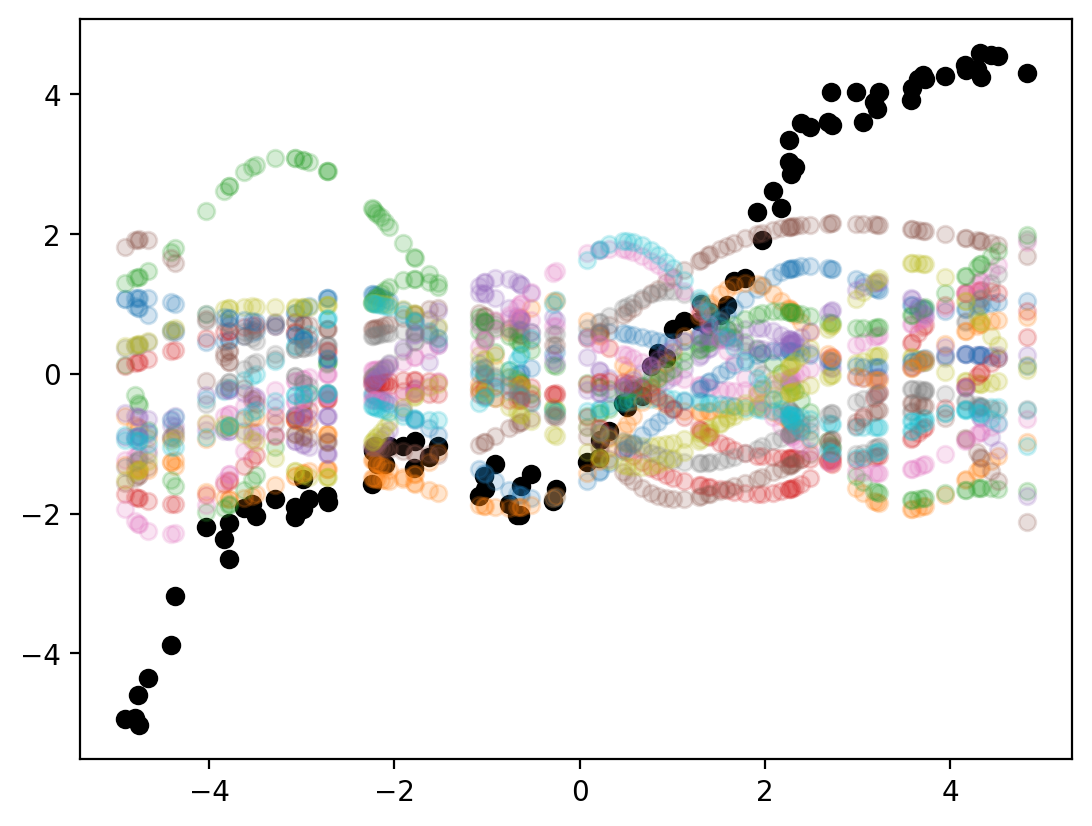

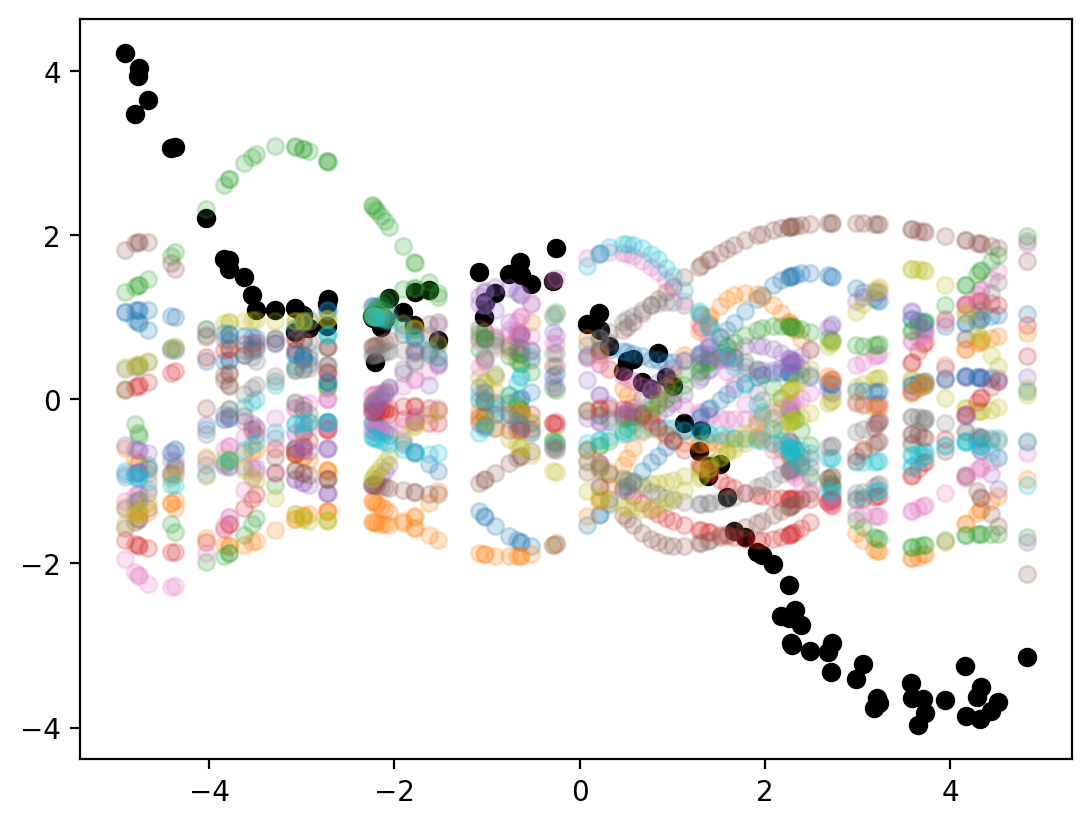

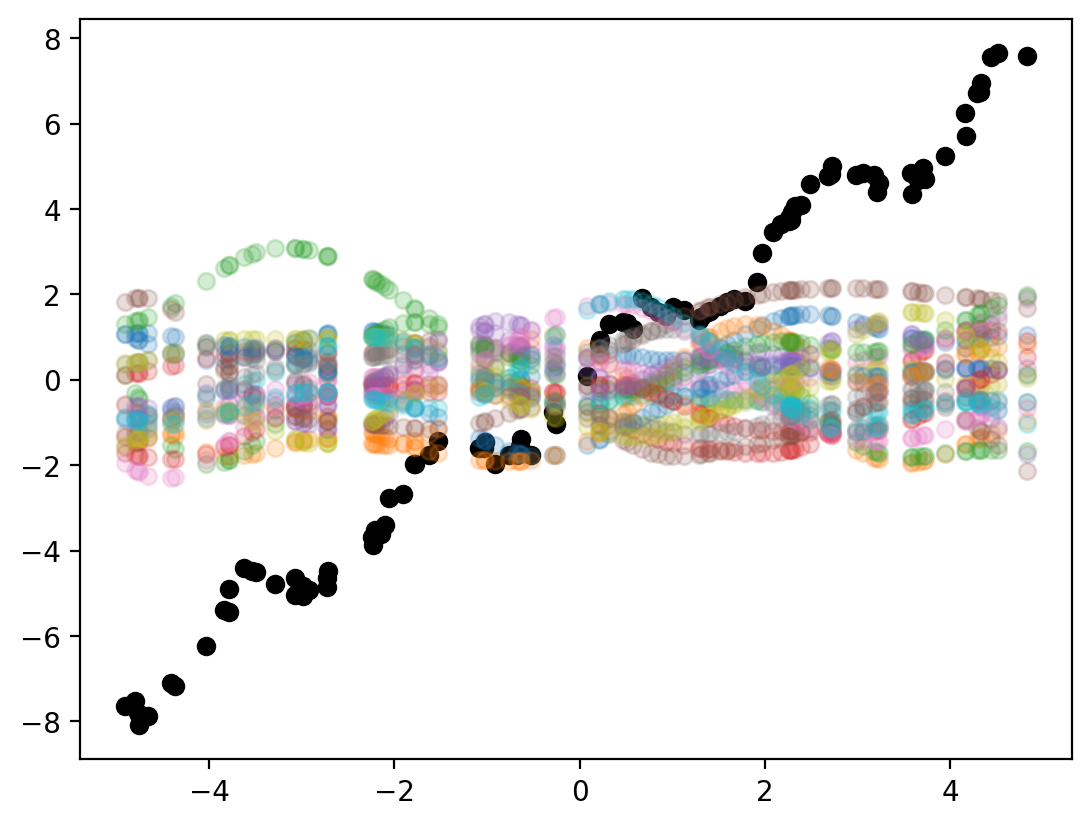

In [17]:
for j in range(num_outputs):
    plt.scatter(X,y[:,j],color='k')
    for i in range(20):
        plt.scatter(X,samples[i,j*num_points:(j+1)*num_points], alpha = 0.2)
    plt.show()

In [19]:
from gpjax.kernels import SharedIndependent

In [21]:
mo_prior = gpx.gps.Prior(mean_function=meanf, kernel=SharedIndependent(gpx.kernels.RBF(),num_outputs))

In [22]:
mo_prior_dist = prior.predict(X)

In [23]:
mo_prior_mean = mo_prior_dist.mean
mo_prior_std = mo_prior_dist.variance
key, subkey = jr.split(key)
mo_samples = mo_prior_dist.sample(key=subkey, sample_shape=(20,))

In [24]:
mo_samples.shape

(20, 100)